# Part 1

### Importing libraries and setting up the datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from numpy import random
import statistics
from statistics import multimode

dataset = pd.read_csv('Apple Sentiment Tweets.csv')
stop_words = pd.read_csv('stop_words.txt')

#formatting the stop_words dataset into a list
stop_words_list = stop_words.values.tolist()    
temp = []

for list_item in stop_words_list:
    for word in list_item:
        temp.append(word)
        
stop_words_list = temp

## Confusion Matrix Plot Function
Function to plot confusion matrix as heat plot

In [2]:
def confusion_matrix_plot(confusion_mat_euc, confusion_mat_man):
    
    fig, ((ax, ax2)) = plt.subplots(1, 2)

    im = ax.imshow(confusion_mat_euc, cmap='Blues')
    im = ax2.imshow(confusion_mat_man, cmap='Blues')

    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax2.set_xticks(np.arange(3))
    ax2.set_yticks(np.arange(3))

    ax.set_xticklabels([1, 0, -1])
    ax.set_yticklabels([1, 0, -1])
    ax2.set_xticklabels([1, 0, -1])
    ax2.set_yticklabels([1, 0, -1])

    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, confusion_mat_euc[i, j],
                        ha="center", va="center", color="black")
            text = ax2.text(j, i, confusion_mat_man[i, j],
                        ha="center", va="center", color="black")
            
    ax.tick_params(top=True, bottom=False,
                    labeltop=True, labelbottom=False)
    ax2.tick_params(top=True, bottom=False,
                    labeltop=True, labelbottom=False)
    ax.set_title("Euclidean")
    ax2.set_title("Manhattan")       
    plt.tight_layout()
    plt.show()

## Preprocessing the dataset

In [3]:
tweets = dataset['text']

cleaned_tweets = []

for tweet in tweets:
    temp = re.sub(r'@\w+', ' ', tweet)
    temp = re.sub(r'#', ' ', temp)
    temp = re.sub(r'http[^\s]+', ' ', temp)
    temp = re.sub(r'\r\n', ' ', temp)
    temp = re.sub(r'\$AAPL', ' ', temp)
    temp = re.sub(r'[0-9]', ' ', temp)
    temp = re.sub(r'[A-Z]', lambda x :  x.group(0).lower(), temp)
    temp = re.sub(r'[^a-z \']+', ' ', temp)
    temp = re.sub(r'[ ]+', ' ', temp)
    
    cleaned_tweets.append(temp)
    
#removing the stop words 
cleaned_tweets_stop_words = []
for tweet in cleaned_tweets:
    for word in stop_words_list: 
        
        tweet = re.sub(r"\b{}\b".format(word),"",tweet)
    
    cleaned_tweets_stop_words.append(tweet) 
       
# doing some further cleaning
cleaned_tweets_final = []
for tweet in cleaned_tweets_stop_words:
    
    temp = re.sub(r'\'+', ' ', tweet)
    temp = re.sub(r'\b[a-z]\b', ' ', temp)
    temp = re.sub(r'[ ]+', ' ', temp)
    
    cleaned_tweets_final.append(temp)
    
#making a new dataset containing cleaned tweets
cleaned_dataset = pd.DataFrame(cleaned_tweets_final, columns=['text'])
cleaned_dataset['sentiment'] = dataset['sentiment']
cleaned_dataset = cleaned_dataset[cleaned_dataset.text != ' ']

## Splitting the dataset into test and train

In [4]:
import math

# 20% is for test data while 80% is for training data
test_rows = 0.2*cleaned_dataset.shape[0]
test_rows = math.floor(test_rows)

train_rows = 0.8*cleaned_dataset.shape[0]
train_rows = math.ceil(train_rows)

train_dataset = cleaned_dataset.iloc[0:train_rows, :]
test_dataset = cleaned_dataset.iloc[train_rows:, :]

## Creating the bag of words from training dataset

In [5]:
bag_of_words = []
text = train_dataset['text']

for sentence in text:
    for word in sentence.split():
        if word not in bag_of_words:
            bag_of_words.append(word)

## Creating training and test vectors from bag of words

In [6]:
def create_bow_vectors(sample_list, bag_of_words):
    temp = np.zeros((len(sample_list), len(bag_of_words)))
    
    for i in range(0, len(sample_list)):
        sentence = sample_list[i].split()
        
        for j in range(0, len(bag_of_words)):
            
            temp[i][j] = sentence.count(bag_of_words[j])
            
    return temp
     
# creating vectors for training and test data from bag of words     
train_bow_vectors = create_bow_vectors(list(train_dataset['text']), bag_of_words)
test_bow_vectors = create_bow_vectors(list(test_dataset['text']), bag_of_words)

train_label_vector = train_dataset[['sentiment']].to_numpy()
test_label_vector = test_dataset[['sentiment']].to_numpy()

## k-NN Classifier 
#### parameters = k, x_train, y_train, x_test, distance function
#### return = predicted labels

In [7]:
def kNN(k, train_bow_vectors, train_label_vector, test_bow_vectors, dist_func):
    
    predicted_labels = np.zeros([test_bow_vectors.shape[0],1])
    
    #if the distance is euclidean
    if dist_func == 'e':
        
        for i in range(0, test_bow_vectors.shape[0]):
            
            dist =  np.linalg.norm(train_bow_vectors - test_bow_vectors[i], axis=1, keepdims=True)  #find distance of a test sentence with all training sentences
            k_highest_dist_indexes = (dist).argsort(axis=0)[:k]                                     #pick labels of k nearest training sentences 
            k_nearest_labels = train_label_vector[k_highest_dist_indexes][:,0,0]                    #pick sentiments of those k nearest training sentences
            k_nearest_labels_list = k_nearest_labels.tolist()
            
            mode = statistics.multimode(k_nearest_labels_list)                                      #take mode of sentiments of k nearest training sentences 
            
            while len(mode) != 1:                                                                   #breaking ties
                k_nearest_labels_list.pop()
                mode = statistics.multimode(k_nearest_labels_list)
            
            predicted_labels[i] = mode[0]
            
    #if the distance is manhattan 
    elif dist_func == 'm':
        
        for i in range(0, test_bow_vectors.shape[0]):
            
            dist =  np.linalg.norm(train_bow_vectors - test_bow_vectors[i], axis=1, keepdims=True, ord=1)
            k_highest_dist_indexes = (dist).argsort(axis=0)[:k]
            k_nearest_labels = train_label_vector[k_highest_dist_indexes][:,0,0]
            k_nearest_labels_list = k_nearest_labels.tolist()
            
            mode = statistics.multimode(k_nearest_labels_list)
            
            while len(mode) != 1:
                k_nearest_labels_list.pop()
                mode = statistics.multimode(k_nearest_labels_list)
            
            predicted_labels[i] = mode[0]
            
    return predicted_labels

## Evaluation Function for a single class

In [8]:
def evaluation_single_class(predicted_labels, gold_labels, classno):
    
    confusion_matrix = np.zeros([2,2])
    for i in range(0, gold_labels.shape[0]):
        
        if predicted_labels[i] == classno and gold_labels[i] == classno:
            confusion_matrix[0][0] = confusion_matrix[0][0] + 1
            continue
            
        elif gold_labels[i] == classno and predicted_labels[i] != classno:
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1
            continue
        
        elif gold_labels[i] != classno and predicted_labels[i] == classno:
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1
            continue
            
        elif gold_labels[i] != classno and predicted_labels[i] != classno:
            confusion_matrix[1][1] = confusion_matrix[1][1] + 1
            continue
    
    if (confusion_matrix[0][0] + confusion_matrix[0][1]) == 0:
        precision = 0 
    else:
        precision = confusion_matrix[0][0] /(confusion_matrix[0][0] + confusion_matrix[0][1])
        
    recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
    
    return precision, recall

## Evaluation function for multiclass

In [9]:
def evaluation_classification(predicted_labels, gold_labels):
    
    eval_class1 = evaluation_single_class(predicted_labels, gold_labels, 1)
    eval_class2 = evaluation_single_class(predicted_labels, gold_labels, 0)
    eval_class3 = evaluation_single_class(predicted_labels, gold_labels, -1)
    
    avg_precision = (eval_class1[0] + eval_class2[0] + eval_class3[0]) / 3
    avg_recall = (eval_class1[1] + eval_class2[1] + eval_class3[1]) / 3
    avg_f1 = (2*avg_precision*avg_recall) / (avg_precision + avg_recall)
    
    confusion_matrix = np.zeros([3,3])
    
    for i in range(0, gold_labels.shape[0]):
        
        if predicted_labels[i] == 0 and gold_labels[i] == 0:
            confusion_matrix[0][0] = confusion_matrix[0][0] + 1
            continue
            
        elif gold_labels[i] == 1 and predicted_labels[i] == 0:
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1
            continue
        
        elif gold_labels[i] == -1 and predicted_labels[i] == 0:
            confusion_matrix[0][2] = confusion_matrix[0][2] + 1
            continue
            
        elif gold_labels[i] == 0 and predicted_labels[i] == 1 :
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1
            continue
        
        elif gold_labels[i] == 1 and predicted_labels[i] == 1 :
            confusion_matrix[1][1] = confusion_matrix[1][1] + 1
            continue
        
        elif gold_labels[i] == -1 and predicted_labels[i] == 1 :
            confusion_matrix[1][2] = confusion_matrix[1][2] + 1
            continue
        
        elif gold_labels[i] == 0 and predicted_labels[i] == -1 :
            confusion_matrix[2][0] = confusion_matrix[2][0] + 1
            continue
        
        elif gold_labels[i] == 1 and predicted_labels[i] == -1 :
            confusion_matrix[2][1] = confusion_matrix[2][1] + 1
            continue
        
        elif gold_labels[i] == -1 and predicted_labels[i] == -1 :
            confusion_matrix[2][2] = confusion_matrix[2][2] + 1
            continue
        
    avg_accuracy = (confusion_matrix[1][1] + confusion_matrix[0][0]+ confusion_matrix[2][2]) / np.sum(confusion_matrix)

    return confusion_matrix, avg_accuracy, avg_f1

## 5-Fold Cross Validation Function

In [10]:
def cross_validate(k, train_bow_vectors, train_label_vector):
    
    fold_size = 0.2*train_bow_vectors.shape[0]
    
    avg_confusion_matrix_euclidean = np.zeros([3,3])
    avg_accuracy_euclidean = 0
    avg_f1_euclidean = 0
    
    avg_confusion_matrix_manhattan =  np.zeros([3,3])
    avg_accuracy_manhattan = 0
    avg_f1_manhattan = 0
    
    for i in range(0, 5):
        
        #splitting the training dataset into training and validation set
        train1 = train_bow_vectors[0: int((i*fold_size))]
        train1_labels = train_label_vector[0: int((i*fold_size))]
        
        validate = train_bow_vectors[int((i*fold_size)): int((i*fold_size)+fold_size)]
        validate_labels = train_label_vector[int((i*fold_size)): int((i*fold_size)+fold_size)]
        
        train2 = train_bow_vectors[int((i*fold_size)+fold_size):]
        train2_labels = train_label_vector[int((i*fold_size)+fold_size):]
        
        train = np.vstack((train1, train2))
        train_labels = np.vstack((train1_labels, train2_labels))
        
        #running the classifier for both distances
        predicted_labels_euclidean = kNN(k, train, train_labels, validate, dist_func='e')
        predicted_labels_manhattan = kNN(k, train, train_labels, validate, dist_func='m')
        
        #calculating the evaluation metrics
        avg_eval_euclidean = evaluation_classification(predicted_labels_euclidean, validate_labels)
        avg_eval_manhattan = evaluation_classification(predicted_labels_manhattan, validate_labels)
        
        #adding the evaluation metrics to their respective lists
        avg_confusion_matrix_euclidean = avg_confusion_matrix_euclidean + avg_eval_euclidean[0]
        avg_confusion_matrix_manhattan = avg_confusion_matrix_manhattan + avg_eval_manhattan[0]
        
        avg_accuracy_euclidean = avg_accuracy_euclidean + avg_eval_euclidean[1]
        avg_accuracy_manhattan = avg_accuracy_manhattan + avg_eval_manhattan[1]
        
        avg_f1_euclidean = avg_f1_euclidean + avg_eval_euclidean[2]
        avg_f1_manhattan = avg_f1_manhattan + avg_eval_manhattan[2]
      
    #averaging the evaluation metrics  
    avg_confusion_matrix_euclidean = avg_confusion_matrix_euclidean/5
    avg_confusion_matrix_manhattan = avg_confusion_matrix_manhattan/5
    
    avg_accuracy_euclidean = avg_accuracy_euclidean/5
    avg_accuracy_manhattan = avg_accuracy_manhattan/5
    
    avg_f1_euclidean = avg_f1_euclidean/5
    avg_f1_manhattan = avg_f1_manhattan/5
    
    return (avg_confusion_matrix_euclidean, avg_accuracy_euclidean, avg_f1_euclidean), (avg_confusion_matrix_manhattan, avg_accuracy_manhattan, avg_f1_manhattan)

## 5-Fold Cross-Validation for k=1 to k=10

In [11]:
list_of_evals = []

for k in range(1, 11):
    list_of_evals.append(cross_validate(k, train_bow_vectors, train_label_vector))
    
list_k = [1,2,3,4,5,6,7,8,9,10]

list_of_confusion_matrix_euc = []
list_of_confusion_matrix_man = []

list_of_accuracy_euc = []
list_of_accuracy_man = []

list_of_f1_euc = []
list_of_f1_man = []

for i in range(0, 10):
    list_of_confusion_matrix_euc.append((list_of_evals[i])[0][0])
    list_of_confusion_matrix_man.append(list_of_evals[i][1][0])
    
    list_of_accuracy_euc.append(list_of_evals[i][0][1])
    list_of_accuracy_man.append(list_of_evals[i][1][1])
    
    list_of_f1_euc.append(list_of_evals[i][0][2])
    list_of_f1_man.append(list_of_evals[i][1][2])

## Reporting Results for Cross Validation

,Accuracy_euc,F1_macro_euc,Accuracy_man,F1_macro_man
K,,,,
1,0.640000,0.540224,0.641538,0.542460
2,0.640000,0.540224,0.641538,0.542460
3,0.617692,0.501423,0.616923,0.511252
4,0.620000,0.500039,0.614615,0.498216
5,0.613846,0.493911,0.620000,0.500717
6,0.623846,0.485337,0.624615,0.518181
7,0.626923,0.483751,0.616923,0.505719
8,0.623077,0.472263,0.610769,0.491228
9,0.627692,0.497135,0.618462,0.528185


K= 1


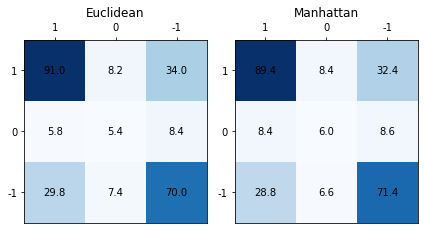

K= 2


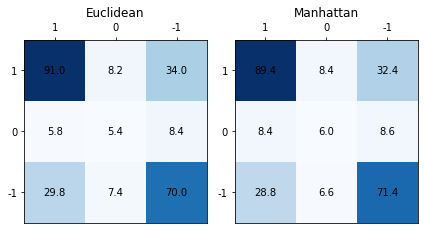

K= 3


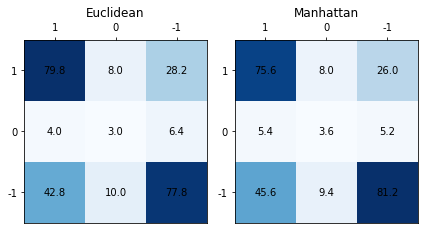

K= 4


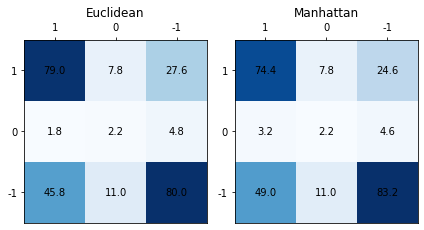

K= 5


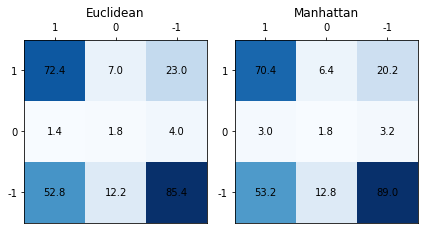

K= 6


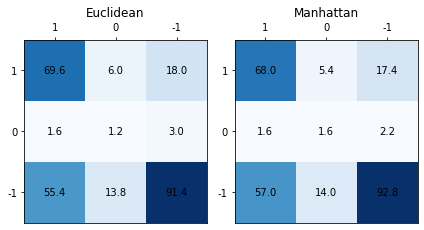

K= 7


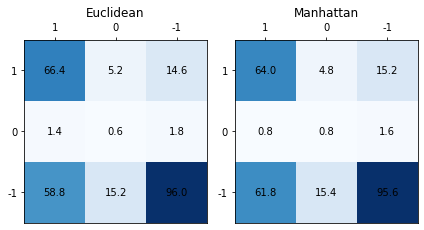

K= 8


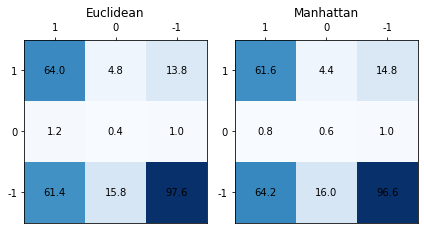

K= 9


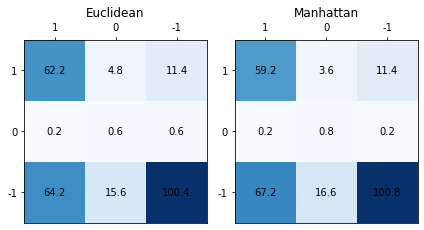

K= 10


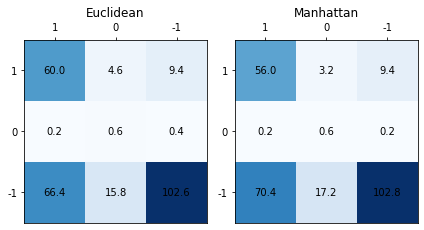

In [12]:
CV_dataframe = pd.DataFrame({'K':list_k, 'Accuracy_euc':list_of_accuracy_euc, 'F1_macro_euc':list_of_f1_euc, 'Accuracy_man':list_of_accuracy_man, 'F1_macro_man':list_of_f1_man })
display(CV_dataframe.set_index('K'))

for i in range(0, 10):
    print('K=', i+1)
    confusion_matrix_plot(list_of_confusion_matrix_euc[i], list_of_confusion_matrix_man[i])

## Plotting Results for Cross Validation 

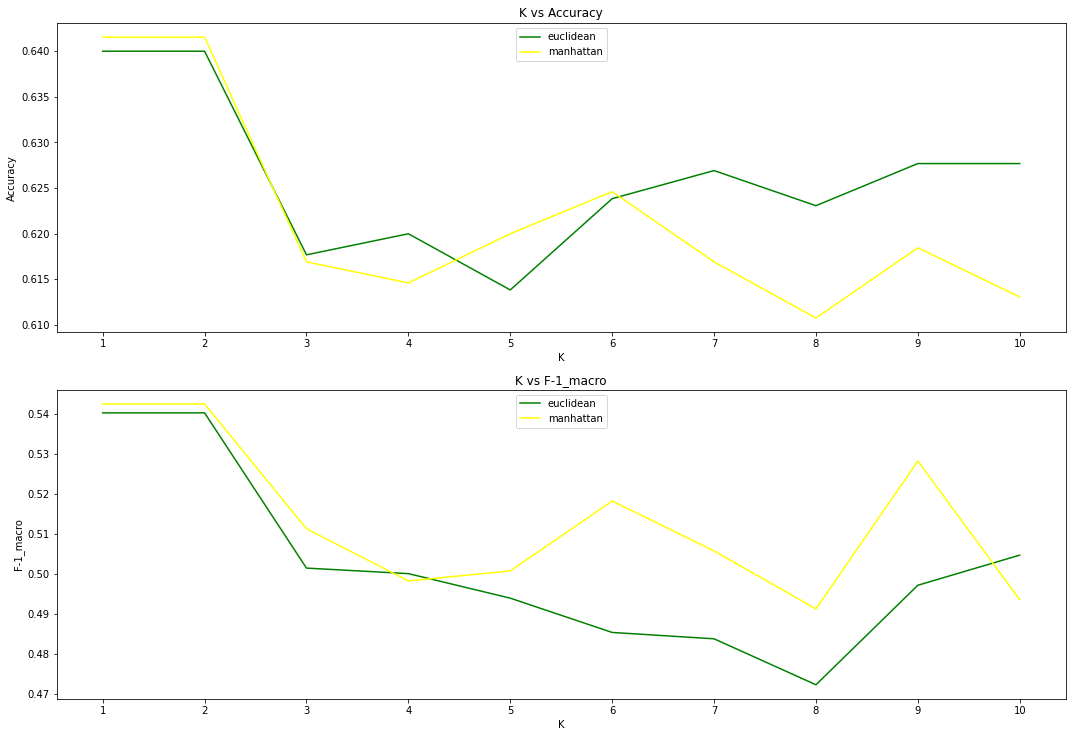

In [13]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.plot(list_k, list_of_accuracy_euc, color = 'green')
plt.plot(list_k, list_of_accuracy_man, color = 'yellow')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(['euclidean', 'manhattan'], loc = 'upper center')
plt.title('K vs Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(3, 1, 2)
plt.plot(list_k, list_of_f1_euc, color = 'green')
plt.plot(list_k, list_of_f1_man, color = 'yellow')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(['euclidean', 'manhattan'], loc = 'upper center')
plt.title('K vs F-1_macro')
plt.xlabel('K')
plt.ylabel('F-1_macro')

plt.tight_layout()
plt.show()

## Comment 
### The best value of K seems to be 2 and 1 both for both manhattan and euclidean distances so it doesn't matter which one we choose because whenever we will break the ties, k=2 will automatically become k=1 hence, the classifier is bound to give similar results for k=1 and k=2.
### Choosing k=2

## Running classifier on test data with K=2

In [14]:
test_predicted_labels_euc = kNN(2, train_bow_vectors, train_label_vector, test_bow_vectors, dist_func='e')
test_predicted_labels_man = kNN(2, train_bow_vectors, train_label_vector, test_bow_vectors, dist_func='m')

test_eval_euc = evaluation_classification(test_predicted_labels_euc, test_label_vector)
test_eval_man = evaluation_classification(test_predicted_labels_man, test_label_vector)

## Reporting Results for Test Data

,Accuracy,F-1_macro
Metric,,
Euclidean,0.649231,0.588873
Manhatten,0.655385,0.594923


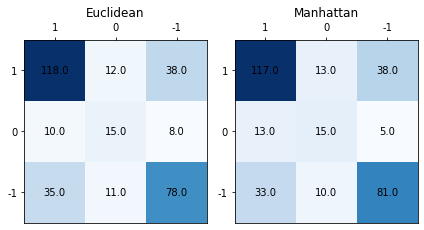

In [15]:
test_dataframe = pd.DataFrame({'Metric':['Euclidean', 'Manhatten'], 'Accuracy':[test_eval_euc[1], test_eval_man[1]], 'F-1_macro':[test_eval_euc[2], test_eval_man[2]]})
display(test_dataframe.set_index('Metric'))

confusion_matrix_plot(test_eval_euc[0], test_eval_man[0])

# PART 2

In [16]:
from sklearn import neighbors
from sklearn import preprocessing as pr
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

## 5-Fold Cross-Validation

In [17]:
accuracy_score_list_euc = []
f1_score_list_euc = []
confusion_matrix_list_euc = []

accuracy_score_list_man = []
f1_score_list_man = []
confusion_matrix_list_man = []

for k in range(1, 11):

    #running the classifier
    classifier_euc = neighbors.KNeighborsClassifier(k, metric='euclidean')
    classifier_man = neighbors.KNeighborsClassifier(k, metric='manhattan')
    
    #doing cross validation
    cross_val_results_euc = cross_val_predict(classifier_euc, train_bow_vectors, train_label_vector.ravel(), cv=5)
    cross_val_results_man = cross_val_predict(classifier_man, train_bow_vectors, train_label_vector.ravel(), cv=5)

    #adding evaluation metrics to their respective lists
    confusion_matrix_list_euc.append(confusion_matrix(train_label_vector, cross_val_results_euc))
    confusion_matrix_list_man.append(confusion_matrix(train_label_vector, cross_val_results_man))
    
    accuracy_score_list_euc.append(accuracy_score(train_label_vector, cross_val_results_euc))
    accuracy_score_list_man.append(accuracy_score(train_label_vector, cross_val_results_man))
    
    f1_score_list_euc.append(f1_score(train_label_vector, cross_val_results_euc, average='macro'))
    f1_score_list_man.append(f1_score(train_label_vector, cross_val_results_man, average='macro'))

## Reporting Results for Cross Validation

,Accuracy_euc,F1_macro_euc,Accuracy_man,F1_macro_man
K,,,,
1,0.635385,0.535925,0.632308,0.535318
2,0.656154,0.488371,0.650769,0.489425
3,0.640000,0.498744,0.633077,0.496537
4,0.633077,0.492530,0.634615,0.496981
5,0.630000,0.463399,0.626154,0.465917
6,0.635385,0.464993,0.626154,0.452661
7,0.627692,0.449165,0.623077,0.450991
8,0.630769,0.465967,0.620769,0.447719
9,0.631538,0.471796,0.623077,0.438497


K= 1


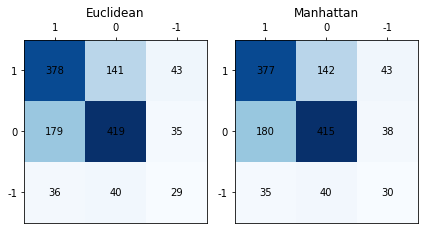

K= 2


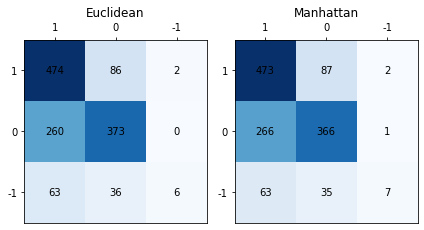

K= 3


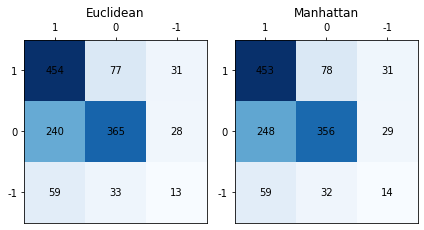

K= 4


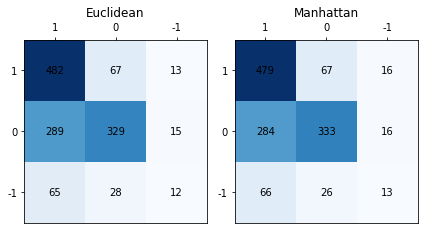

K= 5


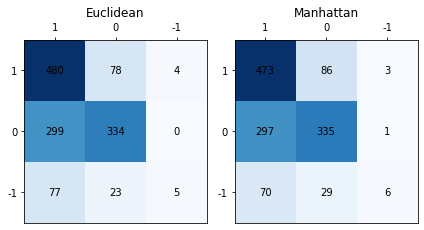

K= 6


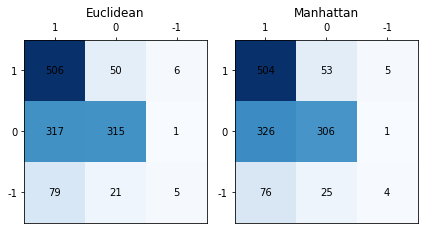

K= 7


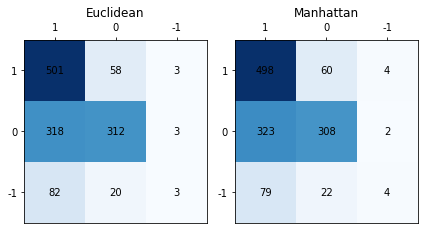

K= 8


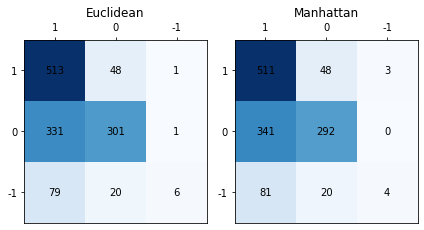

K= 9


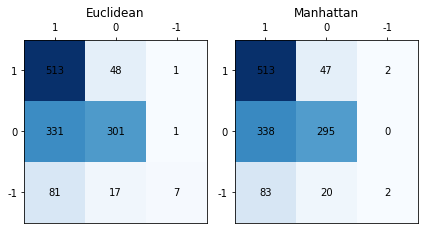

K= 10


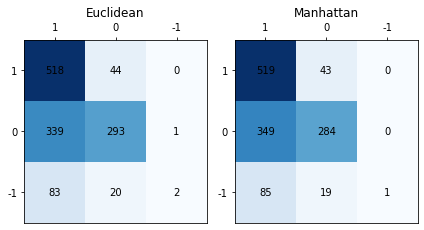

In [18]:
list_k = [1,2,3,4,5,6,7,8,9,10]
CV_result_dataframe = pd.DataFrame({'K':list_k, 'Accuracy_euc':accuracy_score_list_euc, 'F1_macro_euc':f1_score_list_euc, 'Accuracy_man':accuracy_score_list_man, 'F1_macro_man':f1_score_list_man })
display(CV_result_dataframe.set_index('K'))

for i in range(0, 10):
    print('K=', i+1)
    confusion_matrix_plot(confusion_matrix_list_euc[i], confusion_matrix_list_man[i])

## Plotting Results for Cross Validation

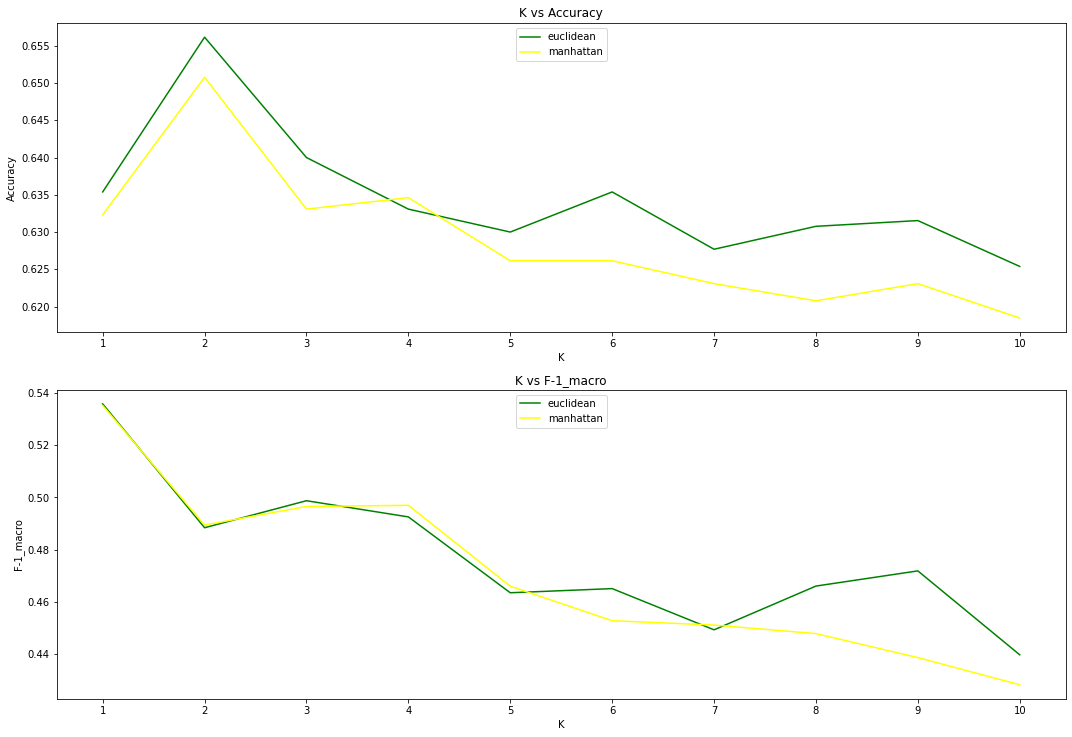

In [19]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.plot(list_k, accuracy_score_list_euc, color = 'green')
plt.plot(list_k, accuracy_score_list_man, color = 'yellow')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(['euclidean', 'manhattan'], loc = 'upper center')
plt.title('K vs Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')

plt.subplot(3, 1, 2)
plt.plot(list_k, f1_score_list_euc, color = 'green')
plt.plot(list_k, f1_score_list_man, color = 'yellow')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend(['euclidean', 'manhattan'], loc = 'upper center')
plt.title('K vs F-1_macro')
plt.xlabel('K')
plt.ylabel('F-1_macro')

plt.tight_layout()
plt.show()

## Comment 
### The best value of K seems to be 1 for both euclidean and manhattan distances

## Running classifier on Test Data for K=1

In [20]:
classifier_test_euc = neighbors.KNeighborsClassifier(1, metric='euclidean')
classifier_test_man = neighbors.KNeighborsClassifier(1, metric='manhattan')

classifier_test_euc.fit(train_bow_vectors, train_label_vector.ravel())
classifier_test_man.fit(train_bow_vectors, train_label_vector.ravel())

predicted_labels_euc = classifier_test_euc.predict(test_bow_vectors)
predicted_labels_man = classifier_test_man.predict(test_bow_vectors)

accuracy_score_euc = (metrics.accuracy_score(test_label_vector,predicted_labels_euc))
accuracy_score_man = (metrics.accuracy_score(test_label_vector,predicted_labels_man))

confusion_mat_euc = metrics.confusion_matrix(test_label_vector,predicted_labels_euc)
confusion_mat_man = metrics.confusion_matrix(test_label_vector,predicted_labels_man)

f1_score_euc = metrics.f1_score(test_label_vector,predicted_labels_euc, average='macro')
f1_score_man = metrics.f1_score(test_label_vector,predicted_labels_man, average='macro')

## Reporting Results for Test Data

,Accuracy,F-1_macro
Metric,,
Euclidean,0.636923,0.602322
Manhatten,0.640000,0.606848


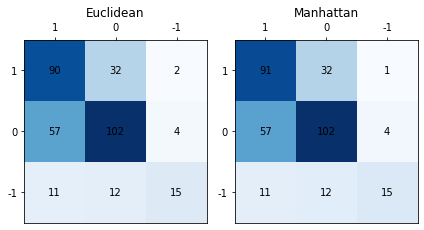

In [21]:
test2_dataframe = pd.DataFrame({'Metric':['Euclidean', 'Manhatten'], 'Accuracy':[accuracy_score_euc, accuracy_score_man], 'F-1_macro':[f1_score_euc, f1_score_man]})
display(test2_dataframe.set_index('Metric'))
confusion_matrix_plot(confusion_mat_euc, confusion_mat_man)